# Imports

In [1]:
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_query import PWEQuery
from PW_explorer.Custom_Visualization_Functions import euler_visualization_nxpd
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import itertools
import PW_explorer as pwe

# Visualization Function

In [2]:
# https://matplotlib.org/gallery/lines_bars_and_markers/timeline.html
from datetime import datetime as datetime
import matplotlib.dates as mdates
def artwork_viz_combined(artwork_df, artist_df, pw_id, start='1825', end='2030'):
    
    artwork_df = artwork_df[artwork_df['pw'] == pw_id]
    artist_df = artist_df[artist_df['pw'] == pw_id]
    artist_color_map = {}
    artist_date_tuples = {}
    artist_artworks = {}
    for i, row in artist_df.iterrows():
        artist_color_map[row['x1']] = np.random.rand(3,)
        artist_date_tuples[row['x1']] = (row['x3'], row['x4'])
    for i, row in artwork_df.iterrows():
        artist_name = row['x2']
        if artist_name not in artist_artworks:
            artist_artworks[artist_name] = []
        artist_artworks[artist_name].append((row['x1'], row['x4']))
    
    tags = ['Today']
    dates = ['2019']
    colors = ['g']
    fig, ax = plt.subplots(figsize=(30, 10))
    levels = np.array([-5, 5, -3, 3, -1, 1])
    for artist in artist_color_map.keys():

        birth = artist_date_tuples[artist][0]
        if birth == '-1' or birth == '0':
            birth = '1800'
            #tags.append('Birth Not Known')
        else:
            tags.append("{}'s Birth".format(artist))
            dates.append(birth)
            colors.append('r')
            
        death = artist_date_tuples[artist][1]
        if death == '-1' or death == '0':
            death = '2019'
            #tags.append('Today')
        else:
            tags.append("{}'s Death".format(artist))
            dates.append(death)
            colors.append('r')
        
        if artist in artist_artworks:
            for artwork, date in artist_artworks[artist]:
                
                if date != '-1':
                    dates.append(date)
                    tags.append("{}'s {}".format(artist,artwork))
                    colors.append('b')
        #print(dates)
    
    dates = list(map(lambda date: datetime.strptime(date, '%Y'), dates))
    start = min(min(dates), datetime.strptime(start, '%Y'))
    stop = max(max(dates), datetime.strptime(end, '%Y'))
    ax.plot((start, stop), (0, 0), 'k', alpha=.5)

    for ii, (iname, idate, color) in enumerate(sorted(zip(tags, dates, colors), key=lambda x: x[1])):
        level = levels[ii % 6]
        vert = 'top' if level < 0 else 'bottom'

        ax.scatter(idate, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)
        # Plot a line up to the text
        ax.plot((idate, idate), (0, level), c=color, alpha=.7, linewidth=7)
        # Give the text a faint background and align it properly
        ax.text(idate, level, iname,
                horizontalalignment='right', verticalalignment=vert, fontsize=20,
                backgroundcolor=(1., 1., 1., .3))
    ax.set(title="Timeline for PW-{}".format(pw_id))
    # Set the xticks formatting
    # format xaxis with 3 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=120))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()

    # Remove components for a cleaner look
    plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
              list(ax.spines.values())), visible=False)
    #plt.show()
    return fig, ax


# Initial Analysis

In [3]:
with open('clingo_files/moma_dataset.lp4') as f:
    clingo_rules = list(map(str.strip, f.readlines()))
print("\n".join(clingo_rules))

% artist(NAME, ID, BIRTHDATE, DEATHDATE)
artist(pablo_picasso, 4609, 1881, 1973).
artist(artko, 18, 0, 0).
artist(yayoi_kusama, 3315, 1929, 0).
artist(picasso, 4609, 1881, 1912).
artist(kusama, 3315, 1829, 1929).

% artwork(TITLE, ARTIST, ARTIST_ID, YEAR_PAINTED)
artwork(seated_woman, pablo_picasso, 4609, 1934).
artwork(war_and_peace, picasso, 4609, 1955).
artwork(flower, yayoi_kusama, 3315, 1953).
artwork(endless, yayoi_kusama, 3315, 1984).
artwork(accumulation, kusama, 3315, 2027).
artwork(war, picasso, 4609, 1988).
artwork(acapulco_gold, artko, 18, 1967).
%artwork(some_picasso_painting, pablo_picasso, 4609, 1911).
%artwork(made_up_name, artko, 18, 1855).

new_artist(NAME, ID, BIRTHDATE, DEATHDATE) :- artist(NAME, ID, BIRTHDATE, DEATHDATE).
new_artwork(TITLE, ARTIST, ARTIST_ID, YEAR_PAINTED) :- artwork(TITLE, ARTIST, ARTIST_ID, YEAR_PAINTED).


In [4]:
clingo_soln = run_clingo(clingo_rules=clingo_rules)
print('\n'.join(clingo_soln))

Answer: 1
artist(pablo_picasso,4609,1881,1973) artist(artko,18,0,0) artist(yayoi_kusama,3315,1929,0) artist(picasso,4609,1881,1912) artist(kusama,3315,1829,1929) new_artist(pablo_picasso,4609,1881,1973) new_artist(artko,18,0,0) new_artist(yayoi_kusama,3315,1929,0) new_artist(picasso,4609,1881,1912) new_artist(kusama,3315,1829,1929) artwork(seated_woman,pablo_picasso,4609,1934) artwork(war_and_peace,picasso,4609,1955) artwork(flower,yayoi_kusama,3315,1953) artwork(endless,yayoi_kusama,3315,1984) artwork(accumulation,kusama,3315,2027) artwork(war,picasso,4609,1988) artwork(acapulco_gold,artko,18,1967) new_artwork(seated_woman,pablo_picasso,4609,1934) new_artwork(war_and_peace,picasso,4609,1955) new_artwork(flower,yayoi_kusama,3315,1953) new_artwork(endless,yayoi_kusama,3315,1984) new_artwork(accumulation,kusama,3315,2027) new_artwork(war,picasso,4609,1988) new_artwork(acapulco_gold,artko,18,1967)
SATISFIABLE

Models       : 1
Calls        : 1
Time         : 0.011s (Solving: 0.00s 1st Mod

In [5]:
dfs, rels, pws = load_worlds(clingo_output=clingo_soln, preprocessed=False, reasoner='clingo')

Number of Models: 1


In [6]:
list(map(lambda x: x.__dict__, rels))

[{'relation_name': 'artist_4', 'arity': 4, 'r_id': 0},
 {'relation_name': 'new_artist_4', 'arity': 4, 'r_id': 1},
 {'relation_name': 'artwork_4', 'arity': 4, 'r_id': 2},
 {'relation_name': 'new_artwork_4', 'arity': 4, 'r_id': 3}]

In [7]:
artists_df_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='new_artist_4', relations=rels)
artworks_df_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='new_artwork_4', relations=rels)

In [8]:
dfs[artists_df_id]

,pw,x1,x2,x3,x4
0,1,pablo_picasso,4609,1881,1973
1,1,artko,18,0,0
2,1,yayoi_kusama,3315,1929,0
3,1,picasso,4609,1881,1912
4,1,kusama,3315,1829,1929


In [9]:
dfs[artworks_df_id]

,pw,x1,x2,x3,x4
0,1,seated_woman,pablo_picasso,4609,1934
1,1,war_and_peace,picasso,4609,1955
2,1,flower,yayoi_kusama,3315,1953
3,1,endless,yayoi_kusama,3315,1984
4,1,accumulation,kusama,3315,2027
5,1,war,picasso,4609,1988
6,1,acapulco_gold,artko,18,1967


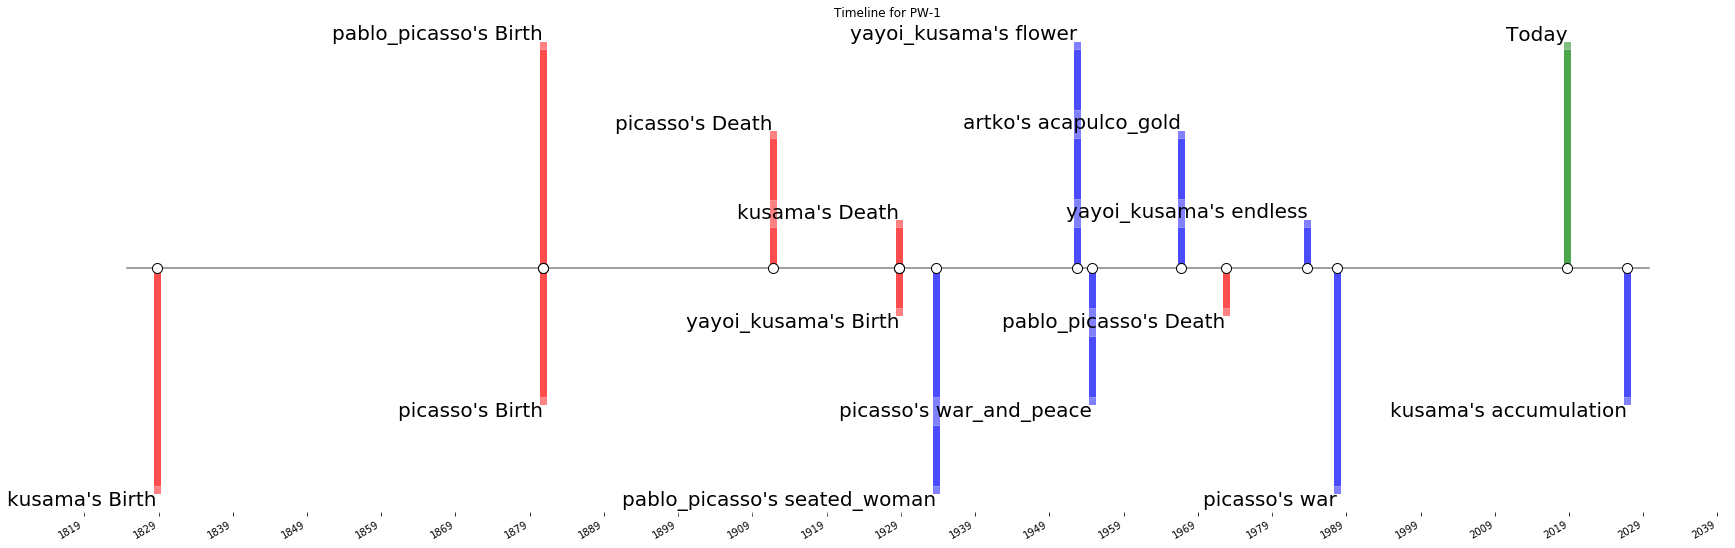

In [10]:
fig, ax = artwork_viz_combined(dfs[artworks_df_id], dfs[artists_df_id], 1)

In [11]:
for ftype in ['pdf', 'svg']:
    fig.savefig(fname='Timeline Visualizations/input.{}'.format(ftype), format=ftype, dpi=1200)
fig.savefig(fname='Timeline Visualizations/input.{}'.format('png'), format='png')

# Adding the integrity constraints to the ASP

In [12]:
with open('clingo_files/moma_dataset_repair.lp4') as f:
    clingo_rules = list(map(str.strip, f.readlines()))
print("\n".join(clingo_rules))

#const current_year=2019.

% artist(NAME, ID, BIRTHDATE, DEATHDATE)
artist(pablo_picasso, 4609, 1881, 1973).
artist(artko, 18, 0, 0).
artist(yayoi_kusama, 3315, 1929, 0).
artist(picasso, 4609, 1881, 1912).
artist(kusama, 3315, 1829, 1929).

% artwork(TITLE, ARTIST, ARTIST_ID, YEAR_PAINTED)
artwork(seated_woman, pablo_picasso, 4609, 1934).
artwork(war_and_peace, picasso, 4609, 1955).
artwork(flower, yayoi_kusama, 3315, 1953).
artwork(endless, yayoi_kusama, 3315, 1984).
artwork(accumulation, kusama, 3315, 2027).
artwork(war, picasso, 4609, 1988).
artwork(acapulco_gold, artko, 18, 1967).
%artwork(some_picasso_painting, pablo_picasso, 4609, 1911).
%artwork(made_up_name, artko, 18, 1855).


% Integrity Constraint Violation for ARTIST_ID (denial):
icv_fd(ID, NAME1, NAME2, X1, Y1, X2, Y2) :- artist(NAME1, ID, X1, Y1), artist(NAME2, ID, X2, Y2), NAME1 != NAME2.

% Make sure there's exactly one record per ARTIST_ID
del_artist(NAME1, ID, X1, Y1) ; del_artist(NAME2,ID, X2,Y2) :- icv_fd(ID,NAME1, 

In [13]:
clingo_soln = run_clingo(clingo_rules=clingo_rules)
print('\n'.join(clingo_soln))

Answer: 1
artist(pablo_picasso,4609,1881,1973) artist(artko,18,0,0) artist(yayoi_kusama,3315,1929,0) artist(picasso,4609,1881,1912) artist(kusama,3315,1829,1929) icv_fd(4609,picasso,pablo_picasso,1881,1912,1881,1973) icv_fd(3315,kusama,yayoi_kusama,1829,1929,1929,0) icv_fd(4609,pablo_picasso,picasso,1881,1973,1881,1912) icv_fd(3315,yayoi_kusama,kusama,1929,0,1829,1929) new_artist(artko,18,0,0) artwork(seated_woman,pablo_picasso,4609,1934) artwork(war_and_peace,picasso,4609,1955) artwork(flower,yayoi_kusama,3315,1953) artwork(endless,yayoi_kusama,3315,1984) artwork(accumulation,kusama,3315,2027) artwork(war,picasso,4609,1988) artwork(acapulco_gold,artko,18,1967) new_artwork(acapulco_gold,artko,18,1967) del_artist(pablo_picasso,4609,1881,1973) del_artist(yayoi_kusama,3315,1929,0) new_artist(picasso,4609,1881,1912) new_artist(kusama,3315,1829,1929) icv_aa(seated_woman,4609) icv_aa(flower,3315) icv_aa(endless,3315) def_date_error(war) def_date_error(seated_woman) def_date_error(war_and_pea

In [14]:
dfs, rels, pws = load_worlds(clingo_output=clingo_soln, preprocessed=False, reasoner='clingo')

Number of Models: 4


In [15]:
list(map(lambda x: x.__dict__, rels))

[{'relation_name': 'artist_4', 'arity': 4, 'r_id': 0},
 {'relation_name': 'icv_fd_7', 'arity': 7, 'r_id': 1},
 {'relation_name': 'new_artist_4', 'arity': 4, 'r_id': 2},
 {'relation_name': 'artwork_4', 'arity': 4, 'r_id': 3},
 {'relation_name': 'new_artwork_4', 'arity': 4, 'r_id': 4},
 {'relation_name': 'del_artist_4', 'arity': 4, 'r_id': 5},
 {'relation_name': 'icv_aa_2', 'arity': 2, 'r_id': 6},
 {'relation_name': 'def_date_error_1', 'arity': 1, 'r_id': 7}]

In [16]:
artists_df_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='new_artist_4', relations=rels)
artworks_df_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='new_artwork_4', relations=rels)

In [17]:
dfs[artists_df_id]

,pw,x1,x2,x3,x4
0,1,artko,18,0,0
1,1,picasso,4609,1881,1912
2,1,kusama,3315,1829,1929
3,2,artko,18,0,0
4,2,yayoi_kusama,3315,1929,0
5,2,picasso,4609,1881,1912
6,3,artko,18,0,0
7,3,pablo_picasso,4609,1881,1973
8,3,kusama,3315,1829,1929
9,4,artko,18,0,0


In [18]:
dfs[artworks_df_id]

,pw,x1,x2,x3,x4
0,1,acapulco_gold,artko,18,1967
1,2,acapulco_gold,artko,18,1967
2,2,flower,yayoi_kusama,3315,1953
3,2,endless,yayoi_kusama,3315,1984
4,3,acapulco_gold,artko,18,1967
5,3,seated_woman,pablo_picasso,4609,1934
6,3,war_and_peace,pablo_picasso,4609,1955
7,4,acapulco_gold,artko,18,1967
8,4,seated_woman,pablo_picasso,4609,1934
9,4,war_and_peace,pablo_picasso,4609,1955


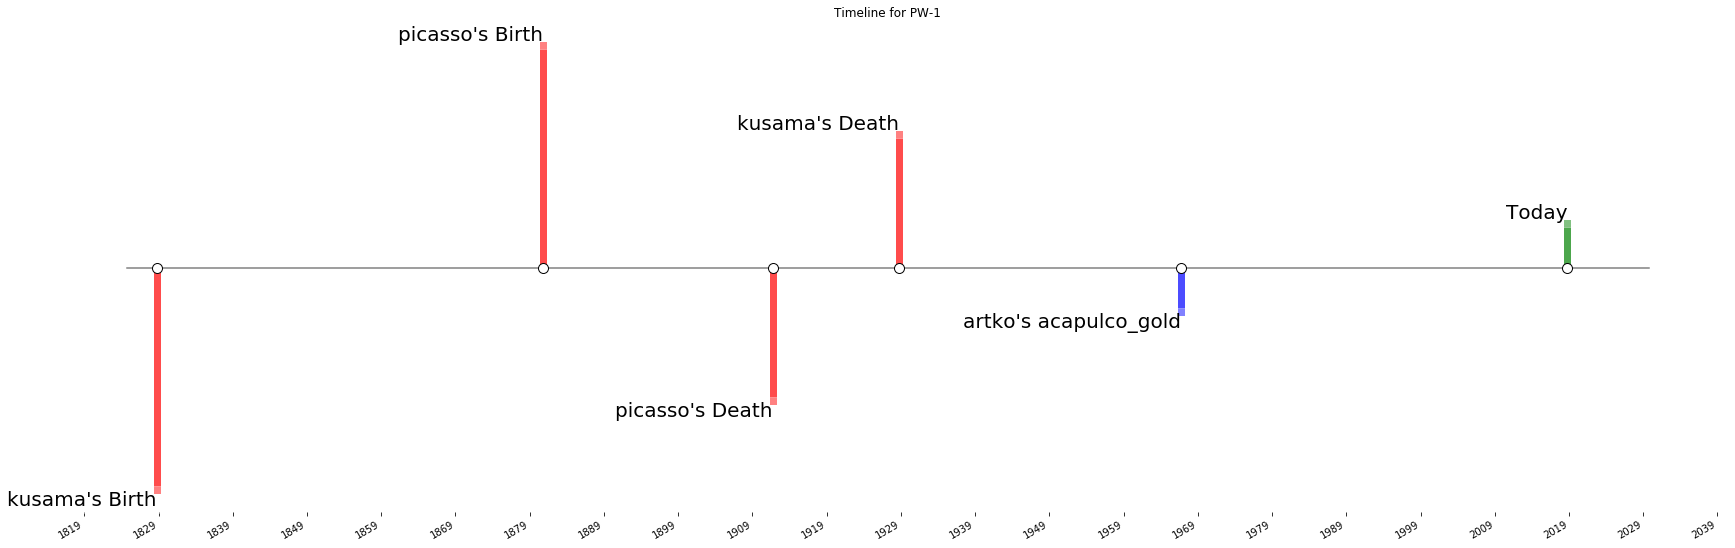

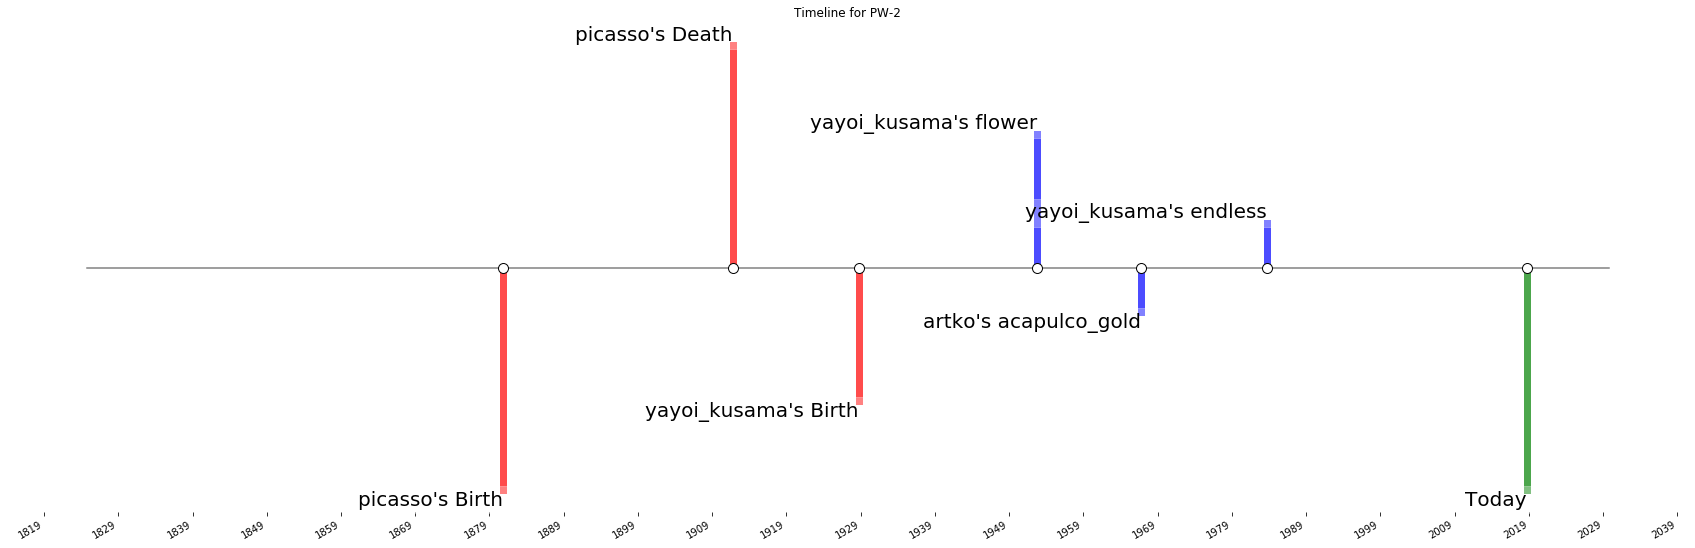

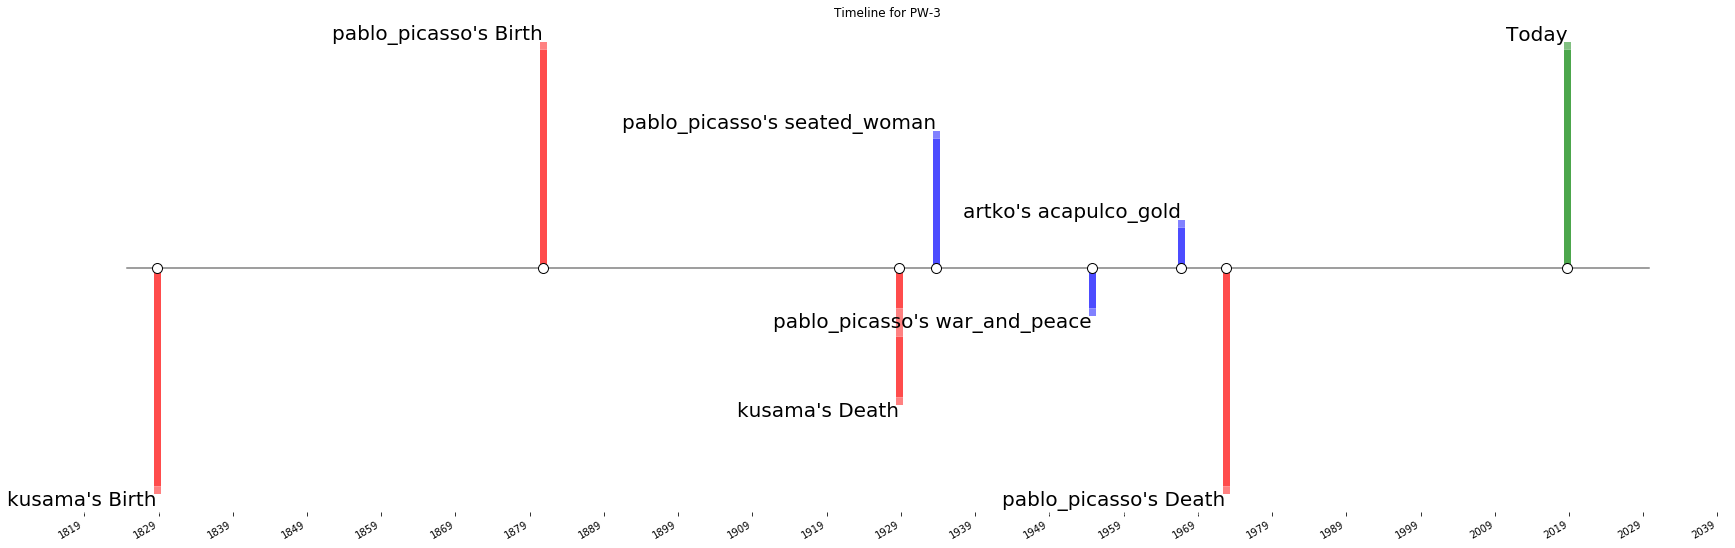

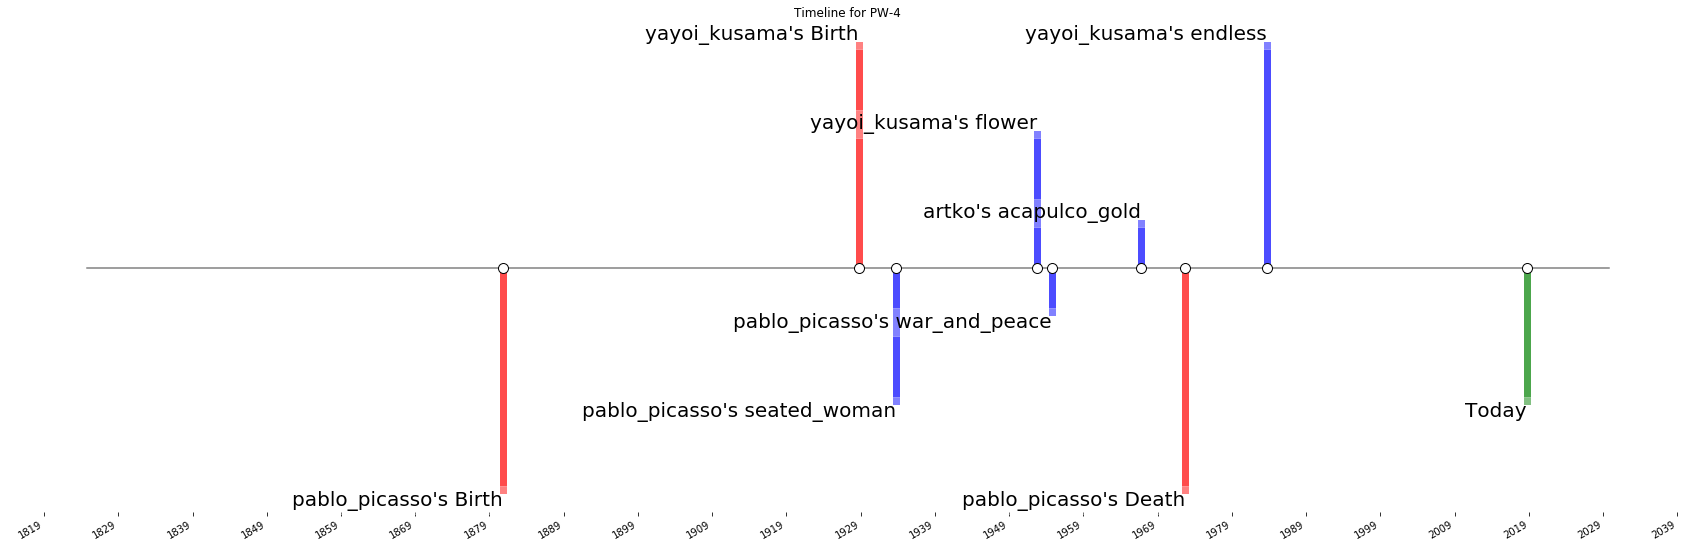

In [19]:
for pw_id in range(1, len(pws)+1):
    fig, ax = artwork_viz_combined(dfs[artworks_df_id], dfs[artists_df_id], pw_id)
    for ftype in ['pdf', 'svg']:
        fig.savefig('Timeline Visualizations/pw_{}.{}'.format(pw_id, ftype), format=ftype, dpi=1200)
    fig.savefig('Timeline Visualizations/pw_{}.{}'.format(pw_id, 'png'), format='png')

In [20]:
num_paintings = [(pw_id, PWEQuery.num_tuples(dfs=dfs,pw_id=pw_id, relations=rels, rl_id=artworks_df_id)) for pw_id in range(1, len(pws)+1)]
num_paintings

There exist 1 tuples of relation new_artwork_4 in PW 1
There exist 3 tuples of relation new_artwork_4 in PW 2
There exist 3 tuples of relation new_artwork_4 in PW 3
There exist 5 tuples of relation new_artwork_4 in PW 4


[(1, 1), (2, 3), (3, 3), (4, 5)]

In [21]:
num_paintings = sorted(num_paintings, key=lambda x: x[1], reverse=True)
num_paintings

[(4, 5), (2, 3), (3, 3), (1, 1)]

(<Figure size 2160x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ca42470>)

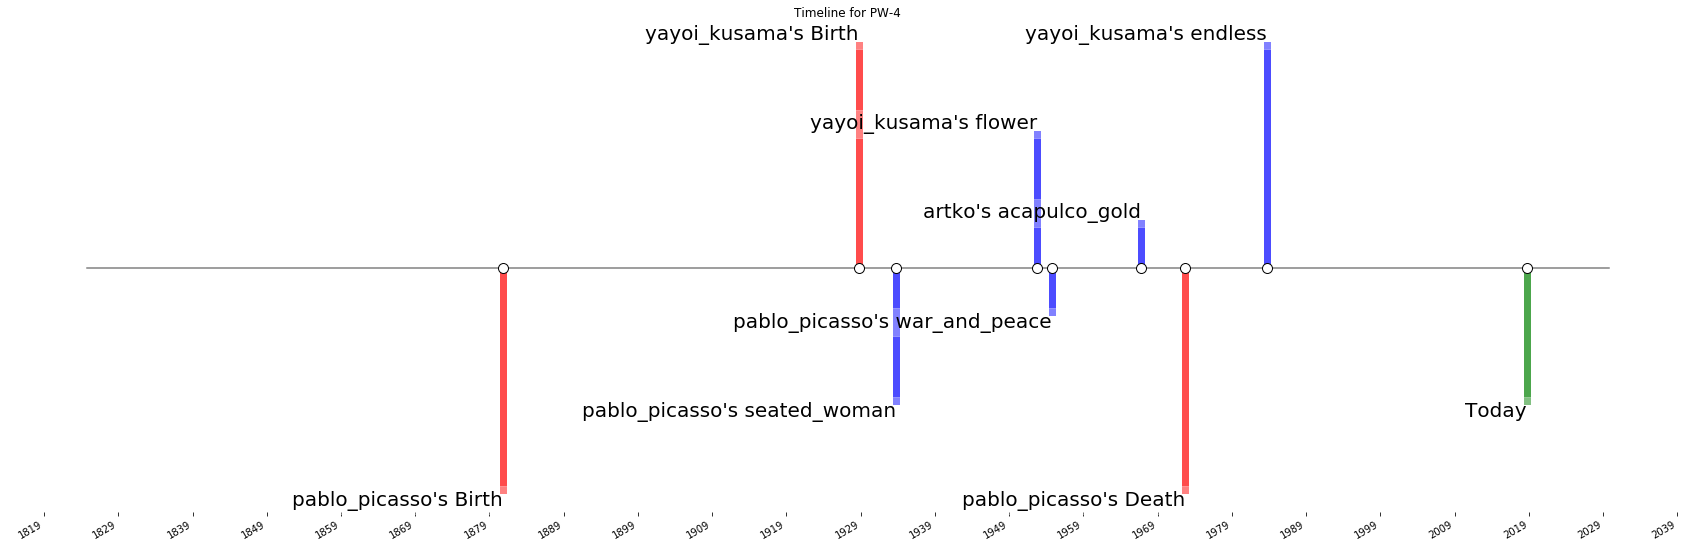

In [22]:
artwork_viz_combined(dfs[artworks_df_id], dfs[artists_df_id], num_paintings[0][0])